# *JunoCam* image mosaicing
This notebook is an example of mosaicing/stacking multiple images from the same perijove pass onto the same lat/lon grid. For an example of projecting single images, see the `projection.ipynb` notebook. That example also covers some of the prerequesites for running the code (e.g., SPICE kernels, etc.). In this example, we'll use two projected images from PJ27 (IDs 8724 and 8761). It is possible to mosaic all the images for a given perijove using this method but is very memory intensive. 

First, we will import the necessary packages (just like the single image example)

In [1]:
from junocam_projection import projector, mosaic
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

KERNEL_DATAFOLDER = "./kernels/"

Now, we will need to project each of the images we want to mosaic onto a lat/lon grid. First, we will process the raw images and get a lat/lon value for each pixel in the image. This is the same as in the single image processing example; it's repeated for each image. 

If you already ran the `projection.ipynb` code, then we can just use the existing data. The `if` statement checks whether the output already exists. We're going to add the filenames to a list so that we can use it later.

In [2]:
files = []
for ID in ["8724", "8761"]:
    proj = projector.Projector(
        "ImageSet/", f"DataSet/{ID}-Metadata.json", KERNEL_DATAFOLDER
    )
    # add the filename of the output to a list to use later
    files.append(proj.fname + ".nc")
    if not os.path.isfile(f"{proj.fname}.nc"):
        proj.process(num_procs=15)
        proj.save(f"{proj.fname}.nc")

Loading data for JNCE_2020154_27C00047_V01
Fetching kernels from NAIF server
Found 26 RGB frames


Finding jitter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:34<00:00,  2.53it/s]


Found best jitter value of -28.0 ms
Loading data for JNCE_2020154_27C00048_V01
Fetching kernels from NAIF server
Found 24 RGB frames


Finding jitter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:33<00:00,  2.56it/s]


Found best jitter value of -27.0 ms


In [3]:
print(files)

['JNCE_2020154_27C00047_V01.nc', 'JNCE_2020154_27C00048_V01.nc']


## Project the image to a global cylindrical projection
Now that we have the backplane information for each frame, we can project each image to a full-globe cylindrical projection. To do this, we load the backplane netCDF file,
apply a simple Lommel-Seeliger correction and project to a cylindrical map.

The `Projector.project_to_[coordinate]` methods all return a `SpatialData` object (see `spatial.py`) which is a data object that retains positional information and allows for saving/loading from GeoTIFF. For now, we just need the data, since we know that this image has a coordinate system of (-180, 180) in longitude and (-90, 90) in latitude.

In [4]:
maps = []
for file in files:
    # use offline mode for the kernels since we know we already have the required kernels
    proj = projector.Projector.load(file, KERNEL_DATAFOLDER, offline=True)

    # apply the Lommel-Seeliger correction
    proj.apply_correction("ls")

    # project the image to full-globe cylindrical projection with 25 pixels per degree
    cylindrical_map = proj.project_to_cylindrical_fullglobe(resolution=25)

    # add the image to our mosaics
    maps.append(cylindrical_map.image / cylindrical_map.image.max())

Fetching kernels from disk
Applying Lommel-Seeliger correction
Calculating image values at new locations


Building image: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6078869/6078869 [00:50<00:00, 120612.47it/s]


Fetching kernels from disk
Applying Lommel-Seeliger correction
Calculating image values at new locations


Building image: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8612847/8612847 [01:10<00:00, 122249.75it/s]


Now, we can call the mosaicing code to stitch the two images together. To do this, we call the `blend_maps` function which contains the following arguments:

  * `maps`: is a sequence of (cylindrically-projected) images as a numpy array (shape: [number of maps, height, width, 3])
  * `sigma_luminance`: is the filter width to remove large scale luminance variations
  * `sigma_filter`: the size below which to filter features (in units of pixels). This will remove low frequency information (such as global brightness variations) at the given pixel size
  * `sigma_cut`: the filter size to trim the edges of the image. Decrease if too much of the image is being trimmed, or increase if there are bright fringes at the edge of each image

**This will take a long time for large images and/or lots of files!**

In [31]:
mosaiced_map = mosaic.blend_maps(np.asarray(maps), sigma_luminance=400, sigma_filter=300, sigma_cut=350)

Applying luminance high pass: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.67s/it]


Creating initial mosaic


Applying high-pass filter: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.83s/it]


Creating high-pass mosaic


Let's plot this out to see what it looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18616039341493826..1.6911014040648689].


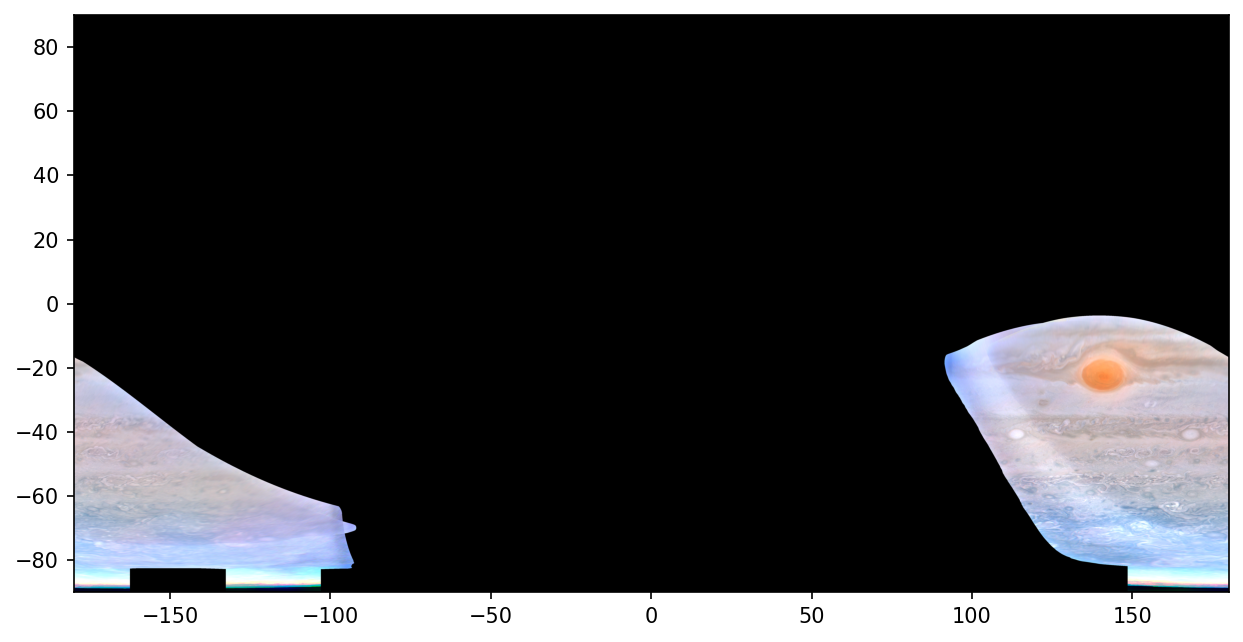

In [32]:
plt.figure(figsize=(10, 5), dpi=150)
plt.imshow(
    mosaiced_map / np.percentile(mosaiced_map, 99),
    extent=(-180, 180, -90, 90),
    origin="lower",
)
plt.show()